In [1]:
#@title Install pre-requisites
!pip install mujoco
!pip install mujoco_mjx
!pip install brax

In [2]:
# @title Check if MuJoCo installation was successful

import distutils.util
import os
import subprocess

if subprocess.run('nvidia-smi').returncode:
  raise RuntimeError(
      'Cannot communicate with GPU. '
      'Make sure you are using a GPU Colab runtime. '
      'Go to the Runtime menu and select Choose runtime type.'
  )

# Add an ICD config so that glvnd can pick up the Nvidia EGL driver.
# This is usually installed as part of an Nvidia driver package, but the Colab
# kernel doesn't install its driver via APT, and as a result the ICD is missing.
# (https://github.com/NVIDIA/libglvnd/blob/master/src/EGL/icd_enumeration.md)
NVIDIA_ICD_CONFIG_PATH = '/usr/share/glvnd/egl_vendor.d/10_nvidia.json'
if not os.path.exists(NVIDIA_ICD_CONFIG_PATH):
  with open(NVIDIA_ICD_CONFIG_PATH, 'w') as f:
    f.write("""{
    "file_format_version" : "1.0.0",
    "ICD" : {
        "library_path" : "libEGL_nvidia.so.0"
    }
}
""")

# Configure MuJoCo to use the EGL rendering backend (requires GPU)
print('Setting environment variable to use GPU rendering:')
%env MUJOCO_GL=egl

try:
  print('Checking that the installation succeeded:')
  import mujoco

  mujoco.MjModel.from_xml_string('<mujoco/>')
except Exception as e:
  raise e from RuntimeError(
      'Something went wrong during installation. Check the shell output above '
      'for more information.\n'
      'If using a hosted Colab runtime, make sure you enable GPU acceleration '
      'by going to the Runtime menu and selecting "Choose runtime type".'
  )

print('Installation successful.')

# Tell XLA to use Triton GEMM, this improves steps/sec by ~30% on some GPUs
xla_flags = os.environ.get('XLA_FLAGS', '')
xla_flags += ' --xla_gpu_triton_gemm_any=True'
os.environ['XLA_FLAGS'] = xla_flags

Setting environment variable to use GPU rendering:
env: MUJOCO_GL=egl
Checking that the installation succeeded:
Installation successful.


In [3]:
# @title Import packages for plotting and creating graphics
import json
import itertools
import time
from typing import Callable, List, NamedTuple, Optional, Union
import numpy as np

# Graphics and plotting.
print("Installing mediapy:")
!command -v ffmpeg >/dev/null || (apt update && apt install -y ffmpeg)
!pip install -q mediapy
import mediapy as media
import matplotlib.pyplot as plt

# More legible printing from numpy.
np.set_printoptions(precision=3, suppress=True, linewidth=100)

Installing mediapy:


In [ ]:
# @title Import MuJoCo, MJX, and Brax
from datetime import datetime
import functools
import os
from typing import Any, Dict, Sequence, Tuple, Union
from brax import base
from brax import envs
from brax import math
from brax.base import Base, Motion, Transform
from brax.base import State as PipelineState
from brax.envs.base import Env, PipelineEnv, State
from brax.io import html, mjcf, model
from brax.mjx.base import State as MjxState
from brax.training.agents.ppo import networks as ppo_networks
from brax.training.agents.ppo import train as ppo
from brax.training.agents.sac import networks as sac_networks
from brax.training.agents.sac import train as sac
from etils import epath
from flax import struct
from flax.training import orbax_utils
from IPython.display import HTML, clear_output
import jax
from jax import numpy as jp
from matplotlib import pyplot as plt
import mediapy as media
from ml_collections import config_dict
import mujoco
from mujoco import mjx
import numpy as np
from orbax import checkpoint as ocp

In [5]:
#@title Install MuJoCo Playground
!pip install playground

In [6]:
#@title Import The Playground

from mujoco_playground import wrapper
from mujoco_playground import registry


registry.locomotion.ALL_ENVS

('BarkourJoystick',
 'BerkeleyHumanoidJoystickFlatTerrain',
 'BerkeleyHumanoidJoystickRoughTerrain',
 'G1JoystickFlatTerrain',
 'G1JoystickRoughTerrain',
 'Go1JoystickFlatTerrain',
 'Go1JoystickRoughTerrain',
 'Go1Getup',
 'Go1Handstand',
 'Go1Footstand',
 'H1InplaceGaitTracking',
 'H1JoystickGaitTracking',
 'Op3Joystick',
 'SpotFlatTerrainJoystick',
 'SpotGetup',
 'SpotJoystickGaitTracking',
 'T1JoystickFlatTerrain',
 'T1JoystickRoughTerrain')

## Other imports

In [7]:
from typing import Any, Dict, Optional, Union, Type

import functools
import jax
import jax.numpy as jp
import numpy as np
from ml_collections import config_dict
import mujoco
from mujoco import mjx
from mujoco.mjx._src import math

from mujoco_playground._src import mjx_env
from mujoco_playground._src import collision

## Go1Env

In [8]:
class Go1Env(mjx_env.MjxEnv):
  """Base class for Go1 environments."""

  def __init__(
      self,
      model_constants: Type,
      xml_path: str,
      get_assets,
      config: config_dict.ConfigDict,
      config_overrides: Optional[Dict[str, Union[str, int, list[Any]]]] = None,
  ) -> None:
    super().__init__(config, config_overrides)
    self.model_constants = model_constants
    self._mj_model = mujoco.MjModel.from_xml_string(
        epath.Path(xml_path).read_text(), assets=get_assets() #xml_path)
    )
    self._mj_model.opt.timestep = self._config.sim_dt

    # Modify PD gains.
    self._mj_model.dof_damping[6:] = config.Kd
    self._mj_model.actuator_gainprm[:, 0] = config.Kp
    self._mj_model.actuator_biasprm[:, 1] = -config.Kp

    # Increase offscreen framebuffer size to render at higher resolutions.
    self._mj_model.vis.global_.offwidth = 3840
    self._mj_model.vis.global_.offheight = 2160

    self._mjx_model = mjx.put_model(self._mj_model)
    self._xml_path = xml_path
    self._imu_site_id = self._mj_model.site("imu").id

  # Sensor readings.

  def get_upvector(self, data: mjx.Data) -> jax.Array:
    return mjx_env.get_sensor_data(self.mj_model, data, self.model_constants.UPVECTOR_SENSOR)

  def get_gravity(self, data: mjx.Data) -> jax.Array:
    return data.site_xmat[self._imu_site_id].T @ jp.array([0, 0, -1])

  def get_global_linvel(self, data: mjx.Data) -> jax.Array:
    return mjx_env.get_sensor_data(
        self.mj_model, data, self.model_constants.GLOBAL_LINVEL_SENSOR
    )

  def get_global_angvel(self, data: mjx.Data) -> jax.Array:
    return mjx_env.get_sensor_data(
        self.mj_model, data, self.model_constants.GLOBAL_ANGVEL_SENSOR
    )

  def get_local_linvel(self, data: mjx.Data) -> jax.Array:
    return mjx_env.get_sensor_data(
        self.mj_model, data, self.model_constants.LOCAL_LINVEL_SENSOR
    )

  def get_accelerometer(self, data: mjx.Data) -> jax.Array:
    return mjx_env.get_sensor_data(
        self.mj_model, data, self.model_constants.ACCELEROMETER_SENSOR
    )

  def get_gyro(self, data: mjx.Data) -> jax.Array:
    return mjx_env.get_sensor_data(self.mj_model, data, self.model_constants.GYRO_SENSOR)

  def get_feet_pos(self, data: mjx.Data) -> jax.Array:
    return jp.vstack([
        mjx_env.get_sensor_data(self.mj_model, data, sensor_name)
        for sensor_name in self.model_constants.FEET_POS_SENSOR
    ])

  # Accessors.

  @property
  def xml_path(self) -> str:
    return self._xml_path

  @property
  def action_size(self) -> int:
    return self._mjx_model.nu

  @property
  def mj_model(self) -> mujoco.MjModel:
    return self._mj_model

  @property
  def mjx_model(self) -> mjx.Model:
    return self._mjx_model

## Define constants

In [9]:
class Go1Constants:

  FEET_SITES = [
      "FR",
      "FL",
      "RR",
      "RL",
  ]

  FEET_GEOMS = [
      "FR",
      "FL",
      "RR",
      "RL",
  ]

  FEET_POS_SENSOR = [f"{site}_pos" for site in FEET_SITES]

  ROOT_BODY = "trunk"

  UPVECTOR_SENSOR = "upvector"
  GLOBAL_LINVEL_SENSOR = "global_linvel"
  GLOBAL_ANGVEL_SENSOR = "global_angvel"
  LOCAL_LINVEL_SENSOR = "local_linvel"
  ACCELEROMETER_SENSOR = "accelerometer"
  GYRO_SENSOR = "gyro"

  ROOT_PATH = mjx_env.ROOT_PATH / "locomotion" / "go1"
  XML_ROOT_PATH = mjx_env.ROOT_PATH / "locomotion" / "go1" / "xmls"
  MENAGERIE_XML_PATH = mjx_env.MENAGERIE_PATH / "unitree_go1"
  FEET_ONLY_FLAT_TERRAIN_XML = (
      ROOT_PATH / "xmls" / "scene_mjx_feetonly_flat_terrain.xml"
  )

  FEET_ONLY_ROUGH_TERRAIN_XML = (
      ROOT_PATH / "xmls" / "scene_mjx_feetonly_rough_terrain.xml"
  )
  FULL_FLAT_TERRAIN_XML = ROOT_PATH / "xmls" / "scene_mjx_flat_terrain.xml"
  FULL_COLLISIONS_FLAT_TERRAIN_XML = (
      ROOT_PATH / "xmls" / "scene_mjx_fullcollisions_flat_terrain.xml"
  )

  @classmethod
  def task_to_xml(cls, task_name: str) -> epath.Path:
      task_map = {
          "flat_terrain": cls.FEET_ONLY_FLAT_TERRAIN_XML,
          "rough_terrain": cls.FEET_ONLY_ROUGH_TERRAIN_XML,
      }
      if task_name not in task_map:
          raise ValueError(f"Invalid task name: {task_name}. Must be one of {list(task_map.keys())}")
      return task_map[task_name]

## Get default config


In [10]:
def default_config() -> config_dict.ConfigDict:
  return config_dict.create(
      ctrl_dt=0.02,
      sim_dt=0.004,
      episode_length=1000,
      Kp=35.0,
      Kd=0.5,
      action_repeat=1,
      action_scale=0.5,
      history_len=1,
      soft_joint_pos_limit_factor=0.95,
      noise_config=config_dict.create(
          level=1.0,  # Set to 0.0 to disable noise.
          scales=config_dict.create(
              joint_pos=0.03,
              joint_vel=1.5,
              gyro=0.2,
              gravity=0.05,
              linvel=0.1,
          ),
      ),
      reward_config=config_dict.create(
          scales=config_dict.create(
              # Tracking.
              tracking_lin_vel=1.0,
              tracking_ang_vel=0.5,
              # Base reward.
              lin_vel_z=-0.5,
              ang_vel_xy=-0.05,
              orientation=-5.0,
              # Other.
              dof_pos_limits=-1.0,
              pose=0.5,
              # Other.
              termination=-1.0,
              stand_still=-1.0,
              # Regularization.
              torques=-0.0002,
              action_rate=-0.01,
              energy=-0.001,
              # Feet.
              feet_clearance=-2.0,
              feet_height=-0.2,
              feet_slip=-0.1,
              feet_air_time=0.1,
          ),
          tracking_sigma=0.25,
          max_foot_height=0.1,
      ),
      pert_config=config_dict.create(
          enable=False,
          velocity_kick=[0.0, 3.0],
          kick_durations=[0.05, 0.2],
          kick_wait_times=[1.0, 3.0],
      ),
      command_config=config_dict.create(
          # Uniform distribution for command amplitude.
          a=[1.5, 0.8, 1.2],
          # Probability of not zeroing out new command.
          b=[0.9, 0.25, 0.5],
      ),
  )

## Go1JoystickEnv

In [11]:
class Go1JoystickEnv(Go1Env):
# class Joystick(go1_base.Go1Env):
  """Track a joystick command."""

  def __init__(
      self,
      model_constants: Type,
      get_assets: Callable,
      task: str = "flat_terrain",
      config: config_dict.ConfigDict = default_config(),
      config_overrides: Optional[Dict[str, Union[str, int, list[Any]]]] = None,
  ):
    super().__init__(
        # xml_path=consts.task_to_xml(task).as_posix(),
        # xml_path=Go1Constants.FEET_ONLY_FLAT_TERRAIN_XML.as_posix(),
        model_constants,
        xml_path=model_constants.task_to_xml(task).as_posix(),
        get_assets=get_assets,
        config=config,
        config_overrides=config_overrides,
    )
    self._post_init()

  def _post_init(self) -> None:
    self._init_q = jp.array(self._mj_model.keyframe("home").qpos)
    self._default_pose = jp.array(self._mj_model.keyframe("home").qpos[7:])

    # Note: First joint is freejoint.
    self._lowers, self._uppers = self.mj_model.jnt_range[1:].T
    self._soft_lowers = self._lowers * self._config.soft_joint_pos_limit_factor
    self._soft_uppers = self._uppers * self._config.soft_joint_pos_limit_factor

    self._torso_body_id = self._mj_model.body(self.model_constants.ROOT_BODY).id
    self._torso_mass = self._mj_model.body_subtreemass[self._torso_body_id]

    self._feet_site_id = np.array(
        [self._mj_model.site(name).id for name in self.model_constants.FEET_SITES]
    )
    self._floor_geom_id = self._mj_model.geom("floor").id
    self._feet_geom_id = np.array(
        [self._mj_model.geom(name).id for name in self.model_constants.FEET_GEOMS]
    )

    foot_linvel_sensor_adr = []
    for site in self.model_constants.FEET_SITES:
      sensor_id = self._mj_model.sensor(f"{site}_global_linvel").id
      sensor_adr = self._mj_model.sensor_adr[sensor_id]
      sensor_dim = self._mj_model.sensor_dim[sensor_id]
      foot_linvel_sensor_adr.append(
          list(range(sensor_adr, sensor_adr + sensor_dim))
      )
    self._foot_linvel_sensor_adr = jp.array(foot_linvel_sensor_adr)

    self._cmd_a = jp.array(self._config.command_config.a)
    self._cmd_b = jp.array(self._config.command_config.b)

  def reset(self, rng: jax.Array) -> mjx_env.State:
    qpos = self._init_q
    qvel = jp.zeros(self.mjx_model.nv)

    # x=+U(-0.5, 0.5), y=+U(-0.5, 0.5), yaw=U(-3.14, 3.14).
    rng, key = jax.random.split(rng)
    dxy = jax.random.uniform(key, (2,), minval=-0.5, maxval=0.5)
    qpos = qpos.at[0:2].set(qpos[0:2] + dxy)
    rng, key = jax.random.split(rng)
    yaw = jax.random.uniform(key, (1,), minval=-3.14, maxval=3.14)
    quat = math.axis_angle_to_quat(jp.array([0, 0, 1]), yaw)
    new_quat = math.quat_mul(qpos[3:7], quat)
    qpos = qpos.at[3:7].set(new_quat)

    # d(xyzrpy)=U(-0.5, 0.5)
    rng, key = jax.random.split(rng)
    qvel = qvel.at[0:6].set(
        jax.random.uniform(key, (6,), minval=-0.5, maxval=0.5)
    )

    data = mjx_env.init(self.mjx_model, qpos=qpos, qvel=qvel, ctrl=qpos[7:])

    rng, key1, key2, key3 = jax.random.split(rng, 4)
    time_until_next_pert = jax.random.uniform(
        key1,
        minval=self._config.pert_config.kick_wait_times[0],
        maxval=self._config.pert_config.kick_wait_times[1],
    )
    steps_until_next_pert = jp.round(time_until_next_pert / self.dt).astype(
        jp.int32
    )
    pert_duration_seconds = jax.random.uniform(
        key2,
        minval=self._config.pert_config.kick_durations[0],
        maxval=self._config.pert_config.kick_durations[1],
    )
    pert_duration_steps = jp.round(pert_duration_seconds / self.dt).astype(
        jp.int32
    )
    pert_mag = jax.random.uniform(
        key3,
        minval=self._config.pert_config.velocity_kick[0],
        maxval=self._config.pert_config.velocity_kick[1],
    )

    rng, key1, key2 = jax.random.split(rng, 3)
    time_until_next_cmd = jax.random.exponential(key1) * 5.0
    steps_until_next_cmd = jp.round(time_until_next_cmd / self.dt).astype(
        jp.int32
    )
    cmd = jax.random.uniform(
        key2, shape=(3,), minval=-self._cmd_a, maxval=self._cmd_a
    )

    info = {
        "rng": rng,
        "command": cmd,
        "steps_until_next_cmd": steps_until_next_cmd,
        "last_act": jp.zeros(self.mjx_model.nu),
        "last_last_act": jp.zeros(self.mjx_model.nu),
        "feet_air_time": jp.zeros(4),
        "last_contact": jp.zeros(4, dtype=bool),
        "swing_peak": jp.zeros(4),
        "steps_until_next_pert": steps_until_next_pert,
        "pert_duration_seconds": pert_duration_seconds,
        "pert_duration": pert_duration_steps,
        "steps_since_last_pert": 0,
        "pert_steps": 0,
        "pert_dir": jp.zeros(3),
        "pert_mag": pert_mag,
    }

    metrics = {}
    for k in self._config.reward_config.scales.keys():
      metrics[f"reward/{k}"] = jp.zeros(())
    metrics["swing_peak"] = jp.zeros(())

    obs = self._get_obs(data, info)
    reward, done = jp.zeros(2)
    return mjx_env.State(data, obs, reward, done, metrics, info)

  # def _reset_if_outside_bounds(self, state: mjx_env.State) -> mjx_env.State:
  #   qpos = state.data.qpos
  #   new_x = jp.where(jp.abs(qpos[0]) > 9.5, 0.0, qpos[0])
  #   new_y = jp.where(jp.abs(qpos[1]) > 9.5, 0.0, qpos[1])
  #   qpos = qpos.at[0:2].set(jp.array([new_x, new_y]))
  #   state = state.replace(data=state.data.replace(qpos=qpos))
  #   return state

  def step(self, state: mjx_env.State, action: jax.Array) -> mjx_env.State:
    if self._config.pert_config.enable:
      state = self._maybe_apply_perturbation(state)
    # state = self._reset_if_outside_bounds(state)

    motor_targets = self._default_pose + action * self._config.action_scale
    data = mjx_env.step(
        self.mjx_model, state.data, motor_targets, self.n_substeps
    )

    contact = jp.array([
        collision.geoms_colliding(data, geom_id, self._floor_geom_id)
        for geom_id in self._feet_geom_id
    ])
    contact_filt = contact | state.info["last_contact"]
    first_contact = (state.info["feet_air_time"] > 0.0) * contact_filt
    state.info["feet_air_time"] += self.dt
    p_f = data.site_xpos[self._feet_site_id]
    p_fz = p_f[..., -1]
    state.info["swing_peak"] = jp.maximum(state.info["swing_peak"], p_fz)

    obs = self._get_obs(data, state.info)
    done = self._get_termination(data)

    rewards = self._get_reward(
        data, action, state.info, state.metrics, done, first_contact, contact
    )
    rewards = {
        k: v * self._config.reward_config.scales[k] for k, v in rewards.items()
    }
    reward = jp.clip(sum(rewards.values()) * self.dt, 0.0, 10000.0)

    state.info["last_last_act"] = state.info["last_act"]
    state.info["last_act"] = action
    state.info["steps_until_next_cmd"] -= 1
    state.info["rng"], key1, key2 = jax.random.split(state.info["rng"], 3)
    state.info["command"] = jp.where(
        state.info["steps_until_next_cmd"] <= 0,
        self.sample_command(key1, state.info["command"]),
        state.info["command"],
    )
    state.info["steps_until_next_cmd"] = jp.where(
        done | (state.info["steps_until_next_cmd"] <= 0),
        jp.round(jax.random.exponential(key2) * 5.0 / self.dt).astype(jp.int32),
        state.info["steps_until_next_cmd"],
    )
    state.info["feet_air_time"] *= ~contact
    state.info["last_contact"] = contact
    state.info["swing_peak"] *= ~contact
    for k, v in rewards.items():
      state.metrics[f"reward/{k}"] = v
    state.metrics["swing_peak"] = jp.mean(state.info["swing_peak"])

    done = done.astype(reward.dtype)
    state = state.replace(data=data, obs=obs, reward=reward, done=done)
    return state

  def _get_termination(self, data: mjx.Data) -> jax.Array:
    fall_termination = self.get_upvector(data)[-1] < 0.0
    return fall_termination

  def _get_obs(
      self, data: mjx.Data, info: dict[str, Any]
  ) -> Dict[str, jax.Array]:
    gyro = self.get_gyro(data)
    info["rng"], noise_rng = jax.random.split(info["rng"])
    noisy_gyro = (
        gyro
        + (2 * jax.random.uniform(noise_rng, shape=gyro.shape) - 1)
        * self._config.noise_config.level
        * self._config.noise_config.scales.gyro
    )

    gravity = self.get_gravity(data)
    info["rng"], noise_rng = jax.random.split(info["rng"])
    noisy_gravity = (
        gravity
        + (2 * jax.random.uniform(noise_rng, shape=gravity.shape) - 1)
        * self._config.noise_config.level
        * self._config.noise_config.scales.gravity
    )

    joint_angles = data.qpos[7:]
    info["rng"], noise_rng = jax.random.split(info["rng"])
    noisy_joint_angles = (
        joint_angles
        + (2 * jax.random.uniform(noise_rng, shape=joint_angles.shape) - 1)
        * self._config.noise_config.level
        * self._config.noise_config.scales.joint_pos
    )

    joint_vel = data.qvel[6:]
    info["rng"], noise_rng = jax.random.split(info["rng"])
    noisy_joint_vel = (
        joint_vel
        + (2 * jax.random.uniform(noise_rng, shape=joint_vel.shape) - 1)
        * self._config.noise_config.level
        * self._config.noise_config.scales.joint_vel
    )

    linvel = self.get_local_linvel(data)
    info["rng"], noise_rng = jax.random.split(info["rng"])
    noisy_linvel = (
        linvel
        + (2 * jax.random.uniform(noise_rng, shape=linvel.shape) - 1)
        * self._config.noise_config.level
        * self._config.noise_config.scales.linvel
    )

    state = jp.hstack([
        noisy_linvel,  # 3
        noisy_gyro,  # 3
        noisy_gravity,  # 3
        noisy_joint_angles - self._default_pose,  # 12
        noisy_joint_vel,  # 12
        info["last_act"],  # 12
        info["command"],  # 3
    ])

    accelerometer = self.get_accelerometer(data)
    angvel = self.get_global_angvel(data)
    feet_vel = data.sensordata[self._foot_linvel_sensor_adr].ravel()

    privileged_state = jp.hstack([
        state,
        gyro,  # 3
        accelerometer,  # 3
        gravity,  # 3
        linvel,  # 3
        angvel,  # 3
        joint_angles - self._default_pose,  # 12
        joint_vel,  # 12
        data.actuator_force,  # 12
        info["last_contact"],  # 4
        feet_vel,  # 4*3
        info["feet_air_time"],  # 4
        data.xfrc_applied[self._torso_body_id, :3],  # 3
        info["steps_since_last_pert"] >= info["steps_until_next_pert"],  # 1
    ])

    return {
        "state": state,
        "privileged_state": privileged_state,
    }

  def _get_reward(
      self,
      data: mjx.Data,
      action: jax.Array,
      info: dict[str, Any],
      metrics: dict[str, Any],
      done: jax.Array,
      first_contact: jax.Array,
      contact: jax.Array,
  ) -> dict[str, jax.Array]:
    del metrics  # Unused.
    return {
        "tracking_lin_vel": self._reward_tracking_lin_vel(
            info["command"], self.get_local_linvel(data)
        ),
        "tracking_ang_vel": self._reward_tracking_ang_vel(
            info["command"], self.get_gyro(data)
        ),
        "lin_vel_z": self._cost_lin_vel_z(self.get_global_linvel(data)),
        "ang_vel_xy": self._cost_ang_vel_xy(self.get_global_angvel(data)),
        "orientation": self._cost_orientation(self.get_upvector(data)),
        "stand_still": self._cost_stand_still(info["command"], data.qpos[7:]),
        "termination": self._cost_termination(done),
        "pose": self._reward_pose(data.qpos[7:]),
        "torques": self._cost_torques(data.actuator_force),
        "action_rate": self._cost_action_rate(
            action, info["last_act"], info["last_last_act"]
        ),
        "energy": self._cost_energy(data.qvel[6:], data.actuator_force),
        "feet_slip": self._cost_feet_slip(data, contact, info),
        "feet_clearance": self._cost_feet_clearance(data),
        "feet_height": self._cost_feet_height(
            info["swing_peak"], first_contact, info
        ),
        "feet_air_time": self._reward_feet_air_time(
            info["feet_air_time"], first_contact, info["command"]
        ),
        "dof_pos_limits": self._cost_joint_pos_limits(data.qpos[7:]),
    }

  # Tracking rewards.

  def _reward_tracking_lin_vel(
      self,
      commands: jax.Array,
      local_vel: jax.Array,
  ) -> jax.Array:
    # Tracking of linear velocity commands (xy axes).
    lin_vel_error = jp.sum(jp.square(commands[:2] - local_vel[:2]))
    return jp.exp(-lin_vel_error / self._config.reward_config.tracking_sigma)

  def _reward_tracking_ang_vel(
      self,
      commands: jax.Array,
      ang_vel: jax.Array,
  ) -> jax.Array:
    # Tracking of angular velocity commands (yaw).
    ang_vel_error = jp.square(commands[2] - ang_vel[2])
    return jp.exp(-ang_vel_error / self._config.reward_config.tracking_sigma)

  # Base-related rewards.

  def _cost_lin_vel_z(self, global_linvel) -> jax.Array:
    # Penalize z axis base linear velocity.
    return jp.square(global_linvel[2])

  def _cost_ang_vel_xy(self, global_angvel) -> jax.Array:
    # Penalize xy axes base angular velocity.
    return jp.sum(jp.square(global_angvel[:2]))

  def _cost_orientation(self, torso_zaxis: jax.Array) -> jax.Array:
    # Penalize non flat base orientation.
    return jp.sum(jp.square(torso_zaxis[:2]))

  # Energy related rewards.

  def _cost_torques(self, torques: jax.Array) -> jax.Array:
    # Penalize torques.
    return jp.sqrt(jp.sum(jp.square(torques))) + jp.sum(jp.abs(torques))

  def _cost_energy(
      self, qvel: jax.Array, qfrc_actuator: jax.Array
  ) -> jax.Array:
    # Penalize energy consumption.
    return jp.sum(jp.abs(qvel) * jp.abs(qfrc_actuator))

  def _cost_action_rate(
      self, act: jax.Array, last_act: jax.Array, last_last_act: jax.Array
  ) -> jax.Array:
    del last_last_act  # Unused.
    return jp.sum(jp.square(act - last_act))

  # Other rewards.

  def _reward_pose(self, qpos: jax.Array) -> jax.Array:
    # Stay close to the default pose.
    weight = jp.array([1.0, 1.0, 0.1] * 4)
    return jp.exp(-jp.sum(jp.square(qpos - self._default_pose) * weight))

  def _cost_stand_still(
      self,
      commands: jax.Array,
      qpos: jax.Array,
  ) -> jax.Array:
    cmd_norm = jp.linalg.norm(commands)
    return jp.sum(jp.abs(qpos - self._default_pose)) * (cmd_norm < 0.01)

  def _cost_termination(self, done: jax.Array) -> jax.Array:
    # Penalize early termination.
    return done

  def _cost_joint_pos_limits(self, qpos: jax.Array) -> jax.Array:
    # Penalize joints if they cross soft limits.
    out_of_limits = -jp.clip(qpos - self._soft_lowers, None, 0.0)
    out_of_limits += jp.clip(qpos - self._soft_uppers, 0.0, None)
    return jp.sum(out_of_limits)

  # Feet related rewards.

  def _cost_feet_slip(
      self, data: mjx.Data, contact: jax.Array, info: dict[str, Any]
  ) -> jax.Array:
    cmd_norm = jp.linalg.norm(info["command"])
    feet_vel = data.sensordata[self._foot_linvel_sensor_adr]
    vel_xy = feet_vel[..., :2]
    vel_xy_norm_sq = jp.sum(jp.square(vel_xy), axis=-1)
    return jp.sum(vel_xy_norm_sq * contact) * (cmd_norm > 0.01)

  def _cost_feet_clearance(self, data: mjx.Data) -> jax.Array:
    feet_vel = data.sensordata[self._foot_linvel_sensor_adr]
    vel_xy = feet_vel[..., :2]
    vel_norm = jp.sqrt(jp.linalg.norm(vel_xy, axis=-1))
    foot_pos = data.site_xpos[self._feet_site_id]
    foot_z = foot_pos[..., -1]
    delta = jp.abs(foot_z - self._config.reward_config.max_foot_height)
    return jp.sum(delta * vel_norm)

  def _cost_feet_height(
      self,
      swing_peak: jax.Array,
      first_contact: jax.Array,
      info: dict[str, Any],
  ) -> jax.Array:
    cmd_norm = jp.linalg.norm(info["command"])
    error = swing_peak / self._config.reward_config.max_foot_height - 1.0
    return jp.sum(jp.square(error) * first_contact) * (cmd_norm > 0.01)

  def _reward_feet_air_time(
      self, air_time: jax.Array, first_contact: jax.Array, commands: jax.Array
  ) -> jax.Array:
    # Reward air time.
    cmd_norm = jp.linalg.norm(commands)
    rew_air_time = jp.sum((air_time - 0.1) * first_contact)
    rew_air_time *= cmd_norm > 0.01  # No reward for zero commands.
    return rew_air_time

  # Perturbation and command sampling.

  def _maybe_apply_perturbation(self, state: mjx_env.State) -> mjx_env.State:
    def gen_dir(rng: jax.Array) -> jax.Array:
      angle = jax.random.uniform(rng, minval=0.0, maxval=jp.pi * 2)
      return jp.array([jp.cos(angle), jp.sin(angle), 0.0])

    def apply_pert(state: mjx_env.State) -> mjx_env.State:
      t = state.info["pert_steps"] * self.dt
      u_t = 0.5 * jp.sin(jp.pi * t / state.info["pert_duration_seconds"])
      # kg * m/s * 1/s = m/s^2 = kg * m/s^2 (N).
      force = (
          u_t  # (unitless)
          * self._torso_mass  # kg
          * state.info["pert_mag"]  # m/s
          / state.info["pert_duration_seconds"]  # 1/s
      )
      xfrc_applied = jp.zeros((self.mjx_model.nbody, 6))
      xfrc_applied = xfrc_applied.at[self._torso_body_id, :3].set(
          force * state.info["pert_dir"]
      )
      data = state.data.replace(xfrc_applied=xfrc_applied)
      state = state.replace(data=data)
      state.info["steps_since_last_pert"] = jp.where(
          state.info["pert_steps"] >= state.info["pert_duration"],
          0,
          state.info["steps_since_last_pert"],
      )
      state.info["pert_steps"] += 1
      return state

    def wait(state: mjx_env.State) -> mjx_env.State:
      state.info["rng"], rng = jax.random.split(state.info["rng"])
      state.info["steps_since_last_pert"] += 1
      xfrc_applied = jp.zeros((self.mjx_model.nbody, 6))
      data = state.data.replace(xfrc_applied=xfrc_applied)
      state.info["pert_steps"] = jp.where(
          state.info["steps_since_last_pert"]
          >= state.info["steps_until_next_pert"],
          0,
          state.info["pert_steps"],
      )
      state.info["pert_dir"] = jp.where(
          state.info["steps_since_last_pert"]
          >= state.info["steps_until_next_pert"],
          gen_dir(rng),
          state.info["pert_dir"],
      )
      return state.replace(data=data)

    return jax.lax.cond(
        state.info["steps_since_last_pert"]
        >= state.info["steps_until_next_pert"],
        apply_pert,
        wait,
        state,
    )

  def sample_command(self, rng: jax.Array, x_k: jax.Array) -> jax.Array:
    rng, y_rng, w_rng, z_rng = jax.random.split(rng, 4)
    y_k = jax.random.uniform(
        y_rng, shape=(3,), minval=-self._cmd_a, maxval=self._cmd_a
    )
    z_k = jax.random.bernoulli(z_rng, self._cmd_b, shape=(3,))
    w_k = jax.random.bernoulli(w_rng, 0.5, shape=(3,))
    x_kp1 = x_k - w_k * (x_k - y_k * z_k)
    return x_kp1

## brax_ppo_config

In [12]:
def brax_ppo_config(env_config) -> config_dict.ConfigDict:
  """Returns tuned Brax PPO config for the given environment."""
  # env_config = default_config() #custom_config # locomotion.get_default_config(env_name)

  rl_config = config_dict.create(
      num_timesteps=100_000_000,
      num_evals=10,
      reward_scaling=1.0,
      episode_length=env_config.episode_length,
      normalize_observations=True,
      action_repeat=1,
      unroll_length=20,
      num_minibatches=32,
      num_updates_per_batch=4,
      discounting=0.97,
      learning_rate=3e-4,
      entropy_cost=1e-2,
      num_envs=8192,
      batch_size=256,
      max_grad_norm=1.0,
      network_factory=config_dict.create(
          policy_hidden_layer_sizes=(128, 128, 128, 128),
          value_hidden_layer_sizes=(256, 256, 256, 256, 256),
          policy_obs_key="state",
          value_obs_key="state",
      ),
  )

  rl_config.num_timesteps = 200_000_000
  rl_config.num_evals = 10
  rl_config.num_resets_per_eval = 1
  rl_config.network_factory = config_dict.create(
      policy_hidden_layer_sizes=(512, 256, 128),
      value_hidden_layer_sizes=(512, 256, 128),
      policy_obs_key="state",
      value_obs_key="privileged_state",
  )

  return rl_config


In [13]:
x_data, y_data, y_dataerr = [], [], []
times = [datetime.now()]


def progress(num_steps, metrics):
  clear_output(wait=True)

  times.append(datetime.now())
  x_data.append(num_steps)
  y_data.append(metrics["eval/episode_reward"])
  y_dataerr.append(metrics["eval/episode_reward_std"])

  plt.xlim([0, ppo_params["num_timesteps"] * 1.25])
  plt.xlabel("# environment steps")
  plt.ylabel("reward per episode")
  plt.title(f"y={y_data[-1]:.3f}")
  plt.errorbar(x_data, y_data, yerr=y_dataerr, color="blue")

  display(plt.gcf())


In [14]:
env_name = 'Go1JoystickFlatTerrain'
env_cfg = registry.get_default_config(env_name)
# env = registry.load(env_name)

## Get randomizer

In [15]:

FLOOR_GEOM_ID = 0
TORSO_BODY_ID = 1


def domain_randomize(model: mjx.Model, rng: jax.Array):
  @jax.vmap
  def rand_dynamics(rng):
    # Floor friction: =U(0.4, 1.0).
    rng, key = jax.random.split(rng)
    geom_friction = model.geom_friction.at[FLOOR_GEOM_ID, 0].set(
        jax.random.uniform(key, minval=0.4, maxval=1.0)
    )

    # Scale static friction: *U(0.9, 1.1).
    rng, key = jax.random.split(rng)
    frictionloss = model.dof_frictionloss[6:] * jax.random.uniform(
        key, shape=(12,), minval=0.9, maxval=1.1
    )
    dof_frictionloss = model.dof_frictionloss.at[6:].set(frictionloss)

    # Scale armature: *U(1.0, 1.05).
    rng, key = jax.random.split(rng)
    armature = model.dof_armature[6:] * jax.random.uniform(
        key, shape=(12,), minval=1.0, maxval=1.05
    )
    dof_armature = model.dof_armature.at[6:].set(armature)

    # Jitter center of mass positiion: +U(-0.05, 0.05).
    rng, key = jax.random.split(rng)
    dpos = jax.random.uniform(key, (3,), minval=-0.05, maxval=0.05)
    body_ipos = model.body_ipos.at[TORSO_BODY_ID].set(
        model.body_ipos[TORSO_BODY_ID] + dpos
    )

    # Scale all link masses: *U(0.9, 1.1).
    rng, key = jax.random.split(rng)
    dmass = jax.random.uniform(
        key, shape=(model.nbody,), minval=0.9, maxval=1.1
    )
    body_mass = model.body_mass.at[:].set(model.body_mass * dmass)

    # Add mass to torso: +U(-1.0, 1.0).
    rng, key = jax.random.split(rng)
    dmass = jax.random.uniform(key, minval=-1.0, maxval=1.0)
    body_mass = body_mass.at[TORSO_BODY_ID].set(
        body_mass[TORSO_BODY_ID] + dmass
    )

    # Jitter qpos0: +U(-0.05, 0.05).
    rng, key = jax.random.split(rng)
    qpos0 = model.qpos0
    qpos0 = qpos0.at[7:].set(
        qpos0[7:]
        + jax.random.uniform(key, shape=(12,), minval=-0.05, maxval=0.05)
    )

    return (
        geom_friction,
        body_ipos,
        body_mass,
        qpos0,
        dof_frictionloss,
        dof_armature,
    )

  (
      friction,
      body_ipos,
      body_mass,
      qpos0,
      dof_frictionloss,
      dof_armature,
  ) = rand_dynamics(rng)

  in_axes = jax.tree_util.tree_map(lambda x: None, model)
  in_axes = in_axes.tree_replace({
      "geom_friction": 0,
      "body_ipos": 0,
      "body_mass": 0,
      "qpos0": 0,
      "dof_frictionloss": 0,
      "dof_armature": 0,
  })

  model = model.tree_replace({
      "geom_friction": friction,
      "body_ipos": body_ipos,
      "body_mass": body_mass,
      "qpos0": qpos0,
      "dof_frictionloss": dof_frictionloss,
      "dof_armature": dof_armature,
  })

  return model, in_axes


randomizer = domain_randomize  # Now `randomizer` refers to the function directly

# Go1 load for training

In [16]:
from abc import ABC, abstractmethod

class TrainingEnvLoader(ABC):
  """
  Abstract base class for loading model constants, configuration, and assets
  for further usage while training.
  """
  def __init__(self):
    self.config = self.set_default_config()
    self.model_constants = self.set_model_constants()

  @abstractmethod
  def set_model_constants(self) -> Type:
    pass


  @abstractmethod
  def get_assets(self) -> Dict[str, bytes]:
    pass


  @abstractmethod
  def set_default_config(self):
    pass


  @abstractmethod
  def get_brax_ppo_config(self):
    pass

  @abstractmethod
  def get_randomizer(self):
    pass

  @abstractmethod
  def get_env(self):
    pass



class Go1JoystickFlatTerrainLoader(TrainingEnvLoader):

  def set_model_constants(self):
    return Go1Constants

  def get_assets(self) -> Dict[str, bytes]:
    assets = {}
    xml_path = self.model_constants.XML_ROOT_PATH
    assets_path = xml_path / "assets"

    # menagerie_xml_path = mjx_env.MENAGERIE_PATH / "unitree_go1"
    menagerie_xml_path = self.model_constants.MENAGERIE_XML_PATH
    menagerie_assets_path = menagerie_xml_path / "assets"

    mjx_env.update_assets(assets, xml_path, "*.xml")
    mjx_env.update_assets(assets, assets_path)

    mjx_env.update_assets(assets, menagerie_xml_path, "*.xml")
    mjx_env.update_assets(assets, menagerie_assets_path)
    return assets


  def set_default_config(self):
    return default_config()

  def get_brax_ppo_config(self):
    return brax_ppo_config(self.config)

  def get_randomizer(self):
    return domain_randomize

  def get_env(self):
    return Go1JoystickEnv(
        self.model_constants,
        get_assets=self.get_assets,
        task="flat_terrain",
        config=self.config,
    )


go1_loader = Go1JoystickFlatTerrainLoader()
go1_js_env_test = go1_loader.get_env()
ppo_params = go1_loader.get_brax_ppo_config()

env_name = 'Go1JoystickFlatTerrain'
env_cfg_ref = registry.get_default_config(env_name)
# env_ref = registry.load(env_name)

# Train

In [17]:
ppo_training_params = dict(ppo_params)
network_factory = ppo_networks.make_ppo_networks
if "network_factory" in ppo_params:
  del ppo_training_params["network_factory"]
  network_factory = functools.partial(
      ppo_networks.make_ppo_networks,
      **ppo_params.network_factory
  )

train_fn = functools.partial(
    ppo.train, **dict(ppo_training_params),
    network_factory=network_factory,
    randomization_fn=randomizer,
    progress_fn=progress
)


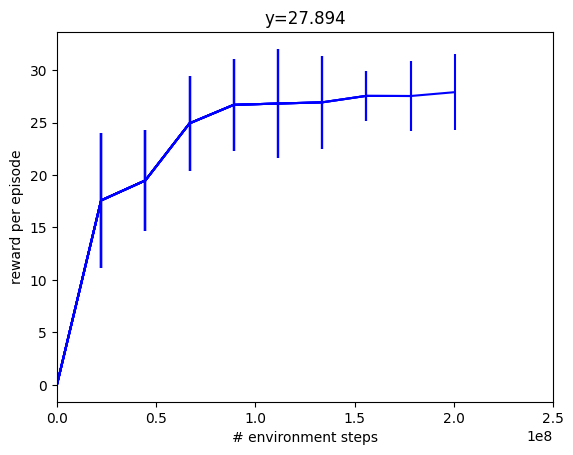

time to jit: 0:02:57.162614
time to train: 0:41:48.935362


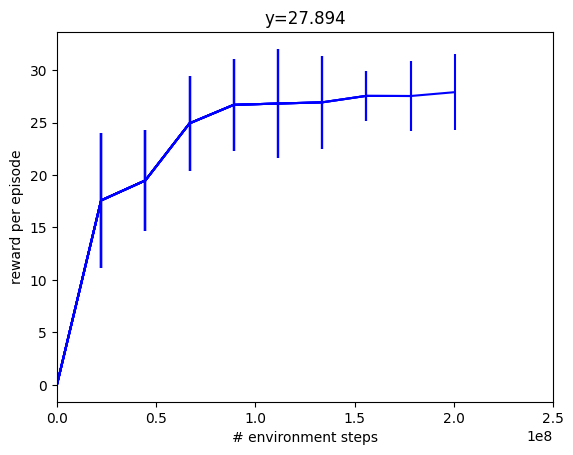

In [18]:
make_inference_fn, params, metrics = train_fn(
    environment=go1_js_env_test, #go1_js_env, #js_env, # env_test_, # go1_js_env, #env,
    eval_env=registry.load(env_name, config=env_cfg),
    wrap_env_fn=wrapper.wrap_for_brax_training,
)
print(f"time to jit: {times[1] - times[0]}")
print(f"time to train: {times[-1] - times[1]}")

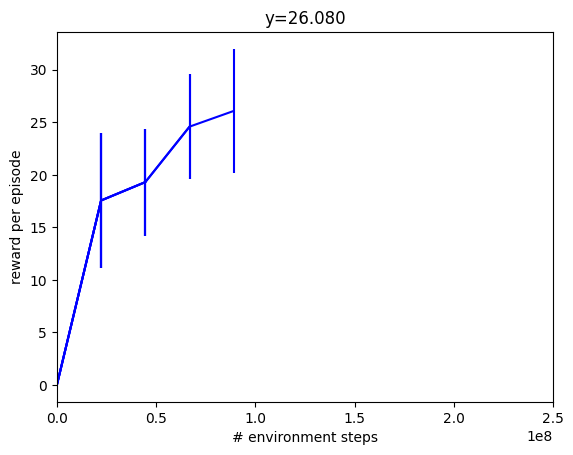

In [ ]:
make_inference_fn, params, metrics = train_fn(
    environment=go1_js_env_test, #go1_js_env, #js_env, # env_test_, # go1_js_env, #env,
    eval_env=registry.load(env_name, config=env_cfg),
    wrap_env_fn=wrapper.wrap_for_brax_training,
)
print(f"time to jit: {times[1] - times[0]}")
print(f"time to train: {times[-1] - times[1]}")

In [ ]:
# Enable perturbation in the eval env.
env_cfg = registry.get_default_config(env_name)
env_cfg.pert_config.enable = True
env_cfg.pert_config.velocity_kick = [3.0, 6.0]
env_cfg.pert_config.kick_wait_times = [5.0, 15.0]
env_cfg.command_config.a = [1.5, 0.8, 2*jp.pi]
eval_env = registry.load(env_name, config=env_cfg)
velocity_kick_range = [0.0, 0.0]  # Disable velocity kick.
kick_duration_range = [0.05, 0.2]

jit_reset = jax.jit(eval_env.reset)
jit_step = jax.jit(eval_env.step)
jit_inference_fn = jax.jit(make_inference_fn(params, deterministic=True))

NameError: name 'make_inference_fn' is not defined

## Go1 Handstand

## Get default config

In [ ]:
def default_config() -> config_dict.ConfigDict:
  return config_dict.create(
      ctrl_dt=0.02,
      sim_dt=0.004,
      episode_length=500,
      Kp=35.0,
      Kd=0.5,
      action_repeat=1,
      action_scale=0.3,
      soft_joint_pos_limit_factor=0.9,
      init_from_crouch=0.0,
      energy_termination_threshold=np.inf,
      noise_config=config_dict.create(
          level=1.0,  # Set to 0.0 to disable noise.
          scales=config_dict.create(
              joint_pos=0.01,
              joint_vel=1.5,
              gyro=0.2,
              gravity=0.05,
              linvel=0.1,
          ),
      ),
      reward_config=config_dict.create(
          scales=config_dict.create(
              height=1.0,
              orientation=1.0,
              contact=-0.1,
              action_rate=0.0,
              termination=0.0,
              dof_pos_limits=-0.5,
              torques=0.0,
              pose=-0.1,
              stay_still=0.0,
              # For finetuning, use energy=-0.003 and dof_acc=-2.5e-7.
              energy=0.0,
              dof_acc=0.0,
          ),
      ),
  )

## Go1Handstand env

In [ ]:
class Handstand(Go1Env):
  """Handstand task for Go1."""

  def __init__(
      self,
      model_constants: Type,
      get_assets: Callable,
      config: config_dict.ConfigDict = default_config(),
      config_overrides: Optional[Dict[str, Union[str, int, list[Any]]]] = None,
  ):
    super().__init__(
        model_constants,
        xml_path=model_constants.FULL_FLAT_TERRAIN_XML.as_posix(),
        get_assets=get_assets,
        config=config,
        config_overrides=config_overrides,
    )
    self._post_init()

  def _post_init(self) -> None:
    self._init_q = jp.array(self._mj_model.keyframe("home").qpos)
    self._handstand_q = jp.array(self._mj_model.keyframe("handstand").qpos)
    self._crouch_q = jp.array(self._mj_model.keyframe("pre_recovery").qpos)
    self._default_pose = jp.array(self._mj_model.keyframe("home").qpos[7:])
    self._handstand_pose = jp.array(
        self._mj_model.keyframe("handstand").qpos[7:]
    )

    self._lowers, self._uppers = self.mj_model.jnt_range[1:].T
    c = (self._lowers + self._uppers) / 2
    r = self._uppers - self._lowers
    self._soft_lowers = c - 0.5 * r * self._config.soft_joint_pos_limit_factor
    self._soft_uppers = c + 0.5 * r * self._config.soft_joint_pos_limit_factor

    self._torso_body_id = self._mj_model.body(self.model_constants.ROOT_BODY).id
    self._feet_site_id = np.array(
        [self._mj_model.site(name).id for name in self.model_constants.FEET_SITES]
    )
    self._floor_geom_id = self._mj_model.geom("floor").id
    self._feet_geom_id = np.array(
        [self._mj_model.geom(name).id for name in self.model_constants.FEET_GEOMS]
    )
    self._z_des = 0.55
    self._desired_forward_vec = jp.array([0, 0, -1])

    self._joint_ids = jp.array([6, 7, 8, 9, 10, 11])
    self._joint_pose = self._default_pose[self._joint_ids]

    geom_names = [
        "fl_calf1",
        "fl_calf2",
        "fr_calf1",
        "fr_calf2",
        "fl_thigh1",
        "fl_thigh2",
        "fl_thigh3",
        "fr_thigh1",
        "fr_thigh2",
        "fr_thigh3",
        "fl_hip",
        "fr_hip",
    ]
    self._unwanted_contact_geom_ids = np.array(
        [self._mj_model.geom(name).id for name in geom_names]
    )

    feet_geom_names = ["RR", "RL"]
    self._feet_geom_ids = np.array(
        [self._mj_model.geom(name).id for name in feet_geom_names]
    )

  def reset(self, rng: jax.Array) -> mjx_env.State:
    rng, reset_rng = jax.random.split(rng)

    init_from_crouch = jax.random.bernoulli(
        reset_rng, self._config.init_from_crouch
    )

    qpos = jp.where(init_from_crouch, self._crouch_q, self._init_q)

    # x=+U(-0.5, 0.5), y=+U(-0.5, 0.5), yaw=U(-3.14, 3.14).
    rng, key = jax.random.split(rng)
    dxy = jax.random.uniform(key, (2,), minval=-0.5, maxval=0.5)
    qpos = qpos.at[0:2].set(qpos[0:2] + dxy)
    rng, key = jax.random.split(rng)
    yaw = jax.random.uniform(key, (1,), minval=-3.14, maxval=3.14)
    quat = math.axis_angle_to_quat(jp.array([0, 0, 1]), yaw)
    new_quat = math.quat_mul(qpos[3:7], quat)
    qpos = qpos.at[3:7].set(new_quat)

    # d(xyzrpy)=U(-0.5, 0.5)
    qvel_nonzero = jp.zeros(self.mjx_model.nv)
    rng, key = jax.random.split(rng)
    qvel_nonzero = qvel_nonzero.at[0:6].set(
        jax.random.uniform(key, (6,), minval=-0.5, maxval=0.5)
    )
    qvel = jp.where(init_from_crouch, jp.zeros(self.mjx_model.nv), qvel_nonzero)

    data = mjx_env.init(self.mjx_model, qpos=qpos, qvel=qvel, ctrl=qpos[7:])

    info = {
        "step": 0,
        "rng": rng,
        "last_act": jp.zeros(self.mjx_model.nu),
    }
    metrics = {}
    for k in self._config.reward_config.scales.keys():
      metrics[f"reward/{k}"] = jp.zeros(())

    contact = jp.array([
        collision.geoms_colliding(data, geom_id, self._floor_geom_id)
        for geom_id in self._unwanted_contact_geom_ids
    ])
    obs = self._get_obs(data, info, contact)
    reward, done = jp.zeros(2)
    return mjx_env.State(data, obs, reward, done, metrics, info)

  def step(self, state: mjx_env.State, action: jax.Array) -> mjx_env.State:
    motor_targets = state.data.ctrl + action * self._config.action_scale
    data = mjx_env.step(
        self.mjx_model, state.data, motor_targets, self.n_substeps
    )

    contact = jp.array([
        collision.geoms_colliding(data, geom_id, self._floor_geom_id)
        for geom_id in self._unwanted_contact_geom_ids
    ])
    obs = self._get_obs(data, state.info, contact)
    done = self._get_termination(data, state.info, contact)

    rewards = self._get_reward(data, action, state.info, done)
    rewards = {
        k: v * self._config.reward_config.scales[k] for k, v in rewards.items()
    }
    reward = jp.clip(sum(rewards.values()) * self.dt, 0.0, 10000.0)

    state.info["step"] += 1
    state.info["last_act"] = action
    for k, v in rewards.items():
      state.metrics[f"reward/{k}"] = v

    done = done.astype(reward.dtype)
    state = state.replace(data=data, obs=obs, reward=reward, done=done)
    return state

  def _get_termination(
      self, data: mjx.Data, info: dict[str, Any], contact: jax.Array
  ) -> jax.Array:
    del info  # Unused.
    fall_termination = self.get_upvector(data)[-1] < -0.25
    contact_termination = jp.any(contact)
    energy = jp.sum(jp.abs(data.actuator_force) * jp.abs(data.qvel[6:]))
    energy_termination = energy > self._config.energy_termination_threshold
    return fall_termination | contact_termination | energy_termination

  def _get_obs(
      self, data: mjx.Data, info: dict[str, Any], contact: jax.Array
  ) -> Dict[str, jax.Array]:
    del contact  # Unused.

    gyro = self.get_gyro(data)
    info["rng"], noise_rng = jax.random.split(info["rng"])
    noisy_gyro = (
        gyro
        + (2 * jax.random.uniform(noise_rng, shape=gyro.shape) - 1)
        * self._config.noise_config.level
        * self._config.noise_config.scales.gyro
    )

    gravity = self.get_gravity(data)
    info["rng"], noise_rng = jax.random.split(info["rng"])
    noisy_gravity = (
        gravity
        + (2 * jax.random.uniform(noise_rng, shape=gravity.shape) - 1)
        * self._config.noise_config.level
        * self._config.noise_config.scales.gravity
    )

    joint_angles = data.qpos[7:]
    info["rng"], noise_rng = jax.random.split(info["rng"])
    noisy_joint_angles = (
        joint_angles
        + (2 * jax.random.uniform(noise_rng, shape=joint_angles.shape) - 1)
        * self._config.noise_config.level
        * self._config.noise_config.scales.joint_pos
    )

    joint_vel = data.qvel[6:]
    info["rng"], noise_rng = jax.random.split(info["rng"])
    noisy_joint_vel = (
        joint_vel
        + (2 * jax.random.uniform(noise_rng, shape=joint_vel.shape) - 1)
        * self._config.noise_config.level
        * self._config.noise_config.scales.joint_vel
    )

    linvel = self.get_local_linvel(data)
    info["rng"], noise_rng = jax.random.split(info["rng"])
    noisy_linvel = (
        linvel
        + (2 * jax.random.uniform(noise_rng, shape=linvel.shape) - 1)
        * self._config.noise_config.level
        * self._config.noise_config.scales.linvel
    )

    state = jp.hstack([
        noisy_linvel,
        noisy_gyro,
        noisy_gravity,
        noisy_joint_angles - self._default_pose,
        noisy_joint_vel,
        info["last_act"],
    ])

    accelerometer = self.get_accelerometer(data)
    linvel = self.get_local_linvel(data)
    angvel = self.get_global_angvel(data)
    torso_height = data.site_xpos[self._imu_site_id][2]

    privileged_state = jp.hstack([
        state,
        gyro,
        accelerometer,
        linvel,
        angvel,
        joint_angles,
        joint_vel,
        data.actuator_force,
        torso_height,
    ])

    return {
        "state": state,
        "privileged_state": privileged_state,
    }

  def _get_reward(
      self,
      data: mjx.Data,
      action: jax.Array,
      info: dict[str, Any],
      done: jax.Array,
  ) -> dict[str, jax.Array]:
    forward = data.site_xmat[self._imu_site_id] @ jp.array([1.0, 0.0, 0.0])
    joint_torques = data.actuator_force
    torso_height = data.site_xpos[self._imu_site_id][2]
    return {
        "height": self._reward_height(torso_height),
        "orientation": self._reward_orientation(
            forward, self._desired_forward_vec
        ),
        "contact": self._cost_contact(data),
        "action_rate": self._cost_action_rate(action, info),
        "torques": self._cost_torques(joint_torques),
        "termination": done,
        "dof_pos_limits": self._cost_joint_pos_limits(data.qpos[7:]),
        "dof_acc": self._cost_dof_acc(data.qacc[6:]),
        "pose": self._cost_pose(data.qpos[7:]),
        "stay_still": self._cost_stay_still(data.qvel[:6]),
        "energy": self._cost_energy(data.qvel[6:], data.actuator_force),
    }

  def _cost_stay_still(self, qvel: jax.Array) -> jax.Array:
    return jp.sum(jp.square(qvel[:2])) + jp.square(qvel[5])

  def _reward_orientation(
      self, forward_vec: jax.Array, up_vec: jax.Array
  ) -> jax.Array:
    cos_dist = jp.dot(forward_vec, up_vec)
    normalized = 0.5 * cos_dist + 0.5
    return jp.square(normalized)

  def _reward_height(self, torso_height: jax.Array) -> jax.Array:
    height = jp.min(jp.array([torso_height, self._z_des]))
    error = self._z_des - height
    return jp.exp(-error / 1.0)

  def _cost_contact(self, data: mjx.Data) -> jax.Array:
    feet_contact = jp.array([
        collision.geoms_colliding(data, geom_id, self._floor_geom_id)
        for geom_id in self._feet_geom_ids
    ])
    return jp.any(feet_contact)

  def _cost_pose(self, qpos: jax.Array) -> jax.Array:
    return jp.sum(jp.square(qpos[self._joint_ids] - self._joint_pose))

  def _cost_torques(self, torques: jax.Array) -> jax.Array:
    return jp.sum(jp.square(torques))

  def _cost_energy(
      self, qvel: jax.Array, qfrc_actuator: jax.Array
  ) -> jax.Array:
    return jp.sum(jp.abs(qvel) * jp.abs(qfrc_actuator))

  def _cost_action_rate(
      self, act: jax.Array, info: dict[str, Any]
  ) -> jax.Array:
    return jp.sum(jp.square(act - info["last_act"]))

  def _cost_joint_pos_limits(self, qpos: jax.Array) -> jax.Array:
    out_of_limits = -jp.clip(qpos - self._soft_lowers, None, 0.0)
    out_of_limits += jp.clip(qpos - self._soft_uppers, 0.0, None)
    return jp.sum(out_of_limits)

  def _cost_dof_acc(self, qacc: jax.Array) -> jax.Array:
    return jp.sum(jp.square(qacc))

## PPO

In [ ]:
def brax_ppo_config(env_config):

  rl_config = config_dict.create(
      num_timesteps=100_000_000,
      num_evals=10,
      reward_scaling=1.0,
      episode_length=env_config.episode_length,
      normalize_observations=True,
      action_repeat=1,
      unroll_length=20,
      num_minibatches=32,
      num_updates_per_batch=4,
      discounting=0.97,
      learning_rate=3e-4,
      entropy_cost=1e-2,
      num_envs=8192,
      batch_size=256,
      max_grad_norm=1.0,
      network_factory=config_dict.create(
          policy_hidden_layer_sizes=(128, 128, 128, 128),
          value_hidden_layer_sizes=(256, 256, 256, 256, 256),
          policy_obs_key="state",
          value_obs_key="state",
      ),
  )

  rl_config.num_timesteps = 100_000_000
  rl_config.num_evals = 5
  rl_config.network_factory = config_dict.create(
      policy_hidden_layer_sizes=(512, 256, 128),
      value_hidden_layer_sizes=(512, 256, 128),
      policy_obs_key="state",
      value_obs_key="privileged_state",
  )

  return rl_config

## Go1HandstandLoader

In [ ]:
class Go1HandstandLoader:
  def __init__(self):
    self.config = self.get_default_config()
    self.model_constants = Go1Constants


  def get_assets(self) -> Dict[str, bytes]:
    assets = {}
    xml_path = self.model_constants.XML_ROOT_PATH
    assets_path = xml_path / "assets"

    menagerie_xml_path = self.model_constants.MENAGERIE_XML_PATH
    menagerie_assets_path = menagerie_xml_path / "assets"

    mjx_env.update_assets(assets, xml_path, "*.xml")
    mjx_env.update_assets(assets, assets_path)

    mjx_env.update_assets(assets, menagerie_xml_path, "*.xml")
    mjx_env.update_assets(assets, menagerie_assets_path)
    return assets


  def get_default_config(self):
    return default_config()

  def get_brax_ppo_config(self):
    return brax_ppo_config(self.config)

  def load_env(self):
    return Handstand(
        self.model_constants,
        get_assets=self.get_assets,
        config=self.config,
    )

  def randomizer(self):
    return domain_randomize



go1_handstand_loader = Go1HandstandLoader()
go1_handstand_env_test = go1_handstand_loader.load_env()
ppo_params = go1_handstand_loader.get_brax_ppo_config()

## Train

In [ ]:
ppo_training_params = dict(ppo_params)
network_factory = ppo_networks.make_ppo_networks
if "network_factory" in ppo_params:
  del ppo_training_params["network_factory"]
  network_factory = functools.partial(
      ppo_networks.make_ppo_networks,
      **ppo_params.network_factory
  )

train_fn = functools.partial(
    ppo.train, **dict(ppo_training_params),
    network_factory=network_factory,
    randomization_fn=randomizer,
    progress_fn=progress
)


In [ ]:
go1_handstand_env_name_ref = 'Go1Handstand'
go1_handstand_env_ref = registry.load(go1_handstand_env_name_ref)
go1_handstand_env_cfg_ref = registry.get_default_config('Go1Handstand') # go1_handstand_env_name_ref)

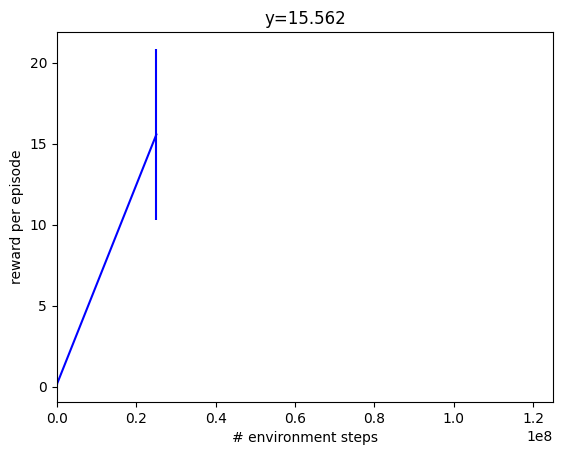

In [ ]:
make_inference_fn, params, metrics = train_fn(
    environment=go1_handstand_env_test, # go1_js_env, #js_env, # env_test_, # go1_js_env, #env,
    eval_env=registry.load(go1_handstand_env_name_ref, config=go1_handstand_env_cfg_ref),
    wrap_env_fn=wrapper.wrap_for_brax_training,
)
print(f"time to jit: {times[1] - times[0]}")
print(f"time to train: {times[-1] - times[1]}")

# Test Fabric

In [20]:
ppo_training_params = dict(ppo_params)
network_factory = ppo_networks.make_ppo_networks
if "network_factory" in ppo_params:
  del ppo_training_params["network_factory"]
  network_factory = functools.partial(
      ppo_networks.make_ppo_networks,
      **ppo_params.network_factory
  )

train_fn = functools.partial(
    ppo.train, **dict(ppo_training_params),
    network_factory=network_factory,
    randomization_fn=randomizer,
    progress_fn=progress
)


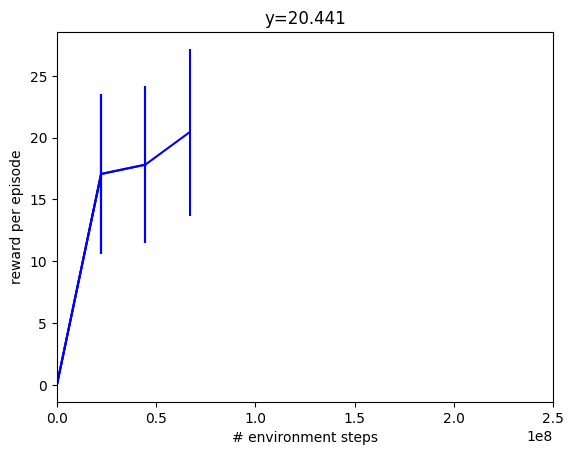

In [ ]:
make_inference_fn, params, metrics = train_fn(
    environment=go1_js_env_test, #env_ref,
    eval_env=registry.load(env_name, config=env_cfg),
    wrap_env_fn=wrapper.wrap_for_brax_training,
)
print(f"time to jit: {times[1] - times[0]}")
print(f"time to train: {times[-1] - times[1]}")